In [1]:
import simplekml
import datetime 

from scipy import fftpack
from scipy.signal import butter,filtfilt, find_peaks
from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pynmea2 as pn

# Setting Up:

In [2]:
FILENAME = '2022_03_29__230253_gps_file.txt'
HEIGHT = 2

DISTANCE_ANOMALY_THESHOLD = 6.3  # in meters

# Data-Preprocessing:
---

### Haversine Formula for calculating the distance between two (latitude, longitude) coordinates:

In [3]:
def haversine_formula( lat_A, lat_B, lon_A, lon_B, R = 3956 ):
    '''
    The halversine formula determines the distance between two points on a sphere given their longitudes and latitudes. 
    R = 3956 is the radius of the Earth in miles.
    '''
    delta_lat = lat_B - lat_A
    delta_lon = lon_B - lon_A
    
    return 2 * R * np.arcsin( np.sqrt(  np.sin( delta_lat/2 )**2 + np.cos(lat_A)*np.cos(lat_B)*np.sin( delta_lon/2 )**2 ) )
    
def distance( coordinate_A, coordinate_B ):
    '''
    Calculates the distance between two latitude and longitude pair coordinates using the haversine formula.
    '''
    lon_A, lat_A = coordinate_A
    lon_B, lat_B = coordinate_B
    
    lon_A, lat_A = np.radians(lon_A), np.radians(lat_A)
    lon_B, lat_B = np.radians(lon_B), np.radians(lat_B)
    
    return haversine_formula( lat_A, lat_B, lon_A, lon_B )

In [4]:
data = { 'Longitude': [], 'Latitude':[], 'Timestamp':[] } # < This is the coordinate data
time_data = [] # < This is the time data in (hours, minutes, seconds, microseconds)
anomalies = set() # < The set of the indexes of anomalous data

# Read the file line-by-line, and parse the GGA messages within.
with open(FILENAME,'r') as gps_file:
    for idx, line in enumerate(gps_file):
        validation = line.count('$') # < The validation variables is simply the number of '$' characters in the string.
        
        if( validation == 0 ):
            continue
        elif( validation == 1 ):
            try:
                gga_msg = pn.parse( line )
                latitude, longitude = gga_msg.latitude, gga_msg.longitude
                
                # If the distance suddenly changes, we ignore those datapoints.
                if( len(data['Latitude']) > 0 ):
                    delta_distance = distance( (data['Longitude'][-1], data['Latitude'][-1]) , (longitude,latitude) )
                    if delta_distance > DISTANCE_ANOMALY_THESHOLD / 1609.34 : # < 1 mi = 1609.34 meters
                        anomalies.add(idx)

                data['Latitude'].append( latitude )
                data['Longitude'].append( longitude )
                
                ts = gga_msg.timestamp 
                time_data.append( [  ts.hour, ts.minute, ts.second, ts.microsecond  ] )
                
            # If something goes wrong with the GGA message decoding, we ignore it and move along.    
            except pn.ChecksumError:
                pass

In [5]:
# We want deal with day-changes ( hour 23 -> hour 0 ) 
# This is because they mess up the total seconds calculation.
time_data = np.array(time_data)
hours = set(time_data[:,0]); 
while (23 in hours and 0 in hours):
    # print('Day change detected!')
    time_data = time_data + np.array([ 1, 0, 0, 0 ])
    time_data[:,0] = time_data[:, 0] % 24
    hours = set(time_data[:,0])

In [6]:
# Store the time data in terms of total seconds
for time in time_data:
    data['Timestamp'].append( time[0]*60*60 + time[1]*60 + time[2] + time[3]/10**6 )

# Ensure the time data is relative to when we fist started. 
data['Timestamp'] = data['Timestamp'] - data['Timestamp'][0]

In [ ]:
dataframe = pd.DataFrame( data ); dataframe

In [8]:
dataframe = dataframe.drop(index=anomalies).drop_duplicates(subset='Timestamp', keep='last')

In [9]:
data = dataframe.to_numpy()

---
## Analyzing the data:

### > Pre Noise-Reduction:

In [10]:
def perform_analysis(data, plot=True):
    '''
    This function calculates the following from the provided data:
        (*) Delta Distances
        (*) Total Distance Traveled
        (*) Velocity
        (*) Deviation Differences 
    Each of these graphs provide keen insight regarding data quality, and the noise and anomalies. 
    '''
    
    time = data[:,2]
    delta_distance = np.array( [ distance( (data[idx][0], data[idx][1] ), (data[max(idx-1,0)][0], data[max(idx-1,0)][1] )) for idx in range(len(data)) ] )
    total_distance_traveled = [ np.sum(delta_distance[:idx]) for idx in range(len(data)) ]
    
    velocity = np.array([ delta_distance[idx] / ( time[idx]-time[max(0,idx-1)] if (time[idx]-time[max(0,idx-1)]) != 0 else 1 ) for idx in range(len(data)) ])
    # Convert per second to per hour
    velocity = velocity * 3600

    if plot:
        # Plot Total Distance Traveled over time
        plt.figure(figsize=(10,4))
        plt.title('Total Distance Traveled')
        plt.ylabel('Miles')
        plt.xlabel('Hours')
        plt.grid()
        plt.plot( time / (60**2) , total_distance_traveled )
        plt.show()

        # Plot Delta Distance over time
        plt.figure(figsize=(15,4))
        plt.title('Delta Distance')
        plt.ylabel('Miles')
        plt.xlabel('Minutes')
        plt.grid()
        plt.plot( time / (60) , delta_distance )
        plt.show()

        # Plot Velocity over time
        plt.figure(figsize=(15,4))
        plt.title('Velocity')
        plt.ylabel('Miles/Hour')
        plt.xlabel('Hours')
        plt.plot( time / 60**2 , velocity )
        plt.grid()
        plt.show()
    
    # Anomaly detection
    rolling_std_dev = [ np.std( delta_distance[:idx] ) for idx in range( 1, len( delta_distance ) ) ]
    deviation_difference = np.diff(rolling_std_dev)

    if plot:
        # Plot Deviation Differences
        plt.figure(figsize=(20,4))
        plt.title('Deviation Differences')
        plt.xlabel('Seconds')
        plt.ylabel('Miles')
        plt.plot( time[2:], deviation_difference )
        plt.grid()
        plt.show()

        # Plot Deviation Differences with the beginning 25% of the graph skipped.
        skip = len(deviation_difference)//4
        plt.figure(figsize=(20,4))
        plt.title('Deviation Differences')
        plt.xlabel('Seconds')
        plt.ylabel('Miles')
        plt.plot( time[2+skip:], deviation_difference[skip:] )
        plt.grid()
        plt.show()

        # Zoomed in Deviation Differences
        plt.figure(figsize=(20,4))
        plt.title('Deviation Differences [Left focused]')
        plt.xlabel('Seconds')
        plt.ylabel('Miles')
        plt.ylim(top = 0.00001, bottom=min(deviation_difference))
        plt.xlim( right = 300 )
        plt.plot( time[2:], deviation_difference )
        plt.grid()
        plt.show()
    
    return {'td':total_distance_traveled, 'dd':delta_distance, 'v':velocity, 'dev':deviation_difference}

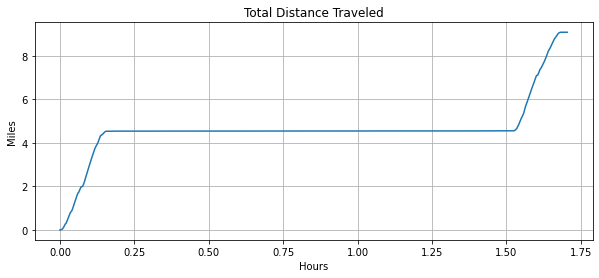

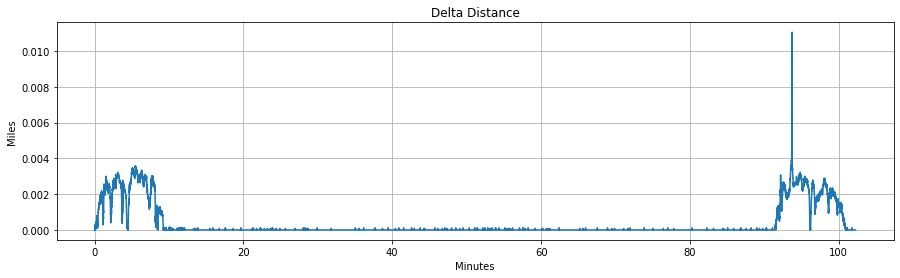

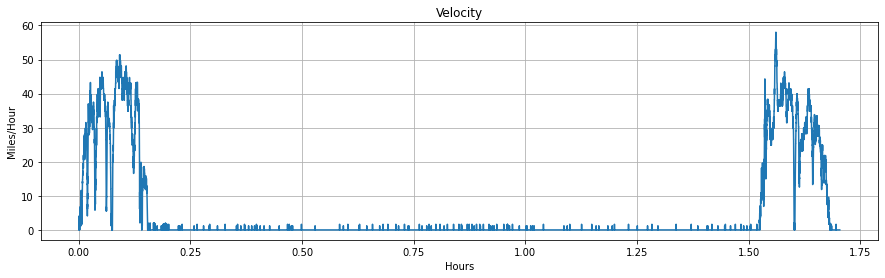

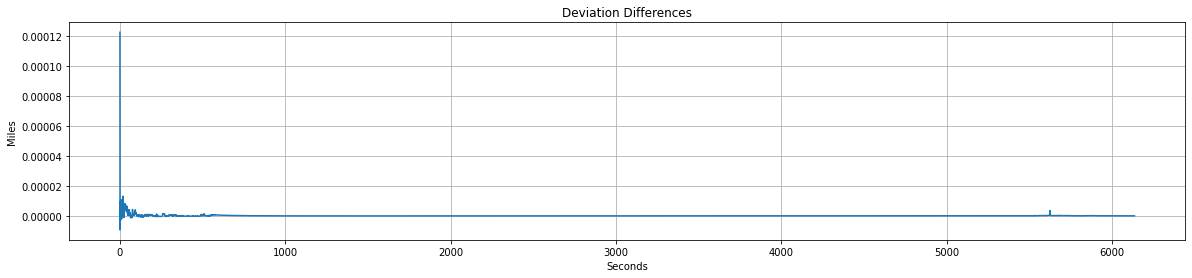

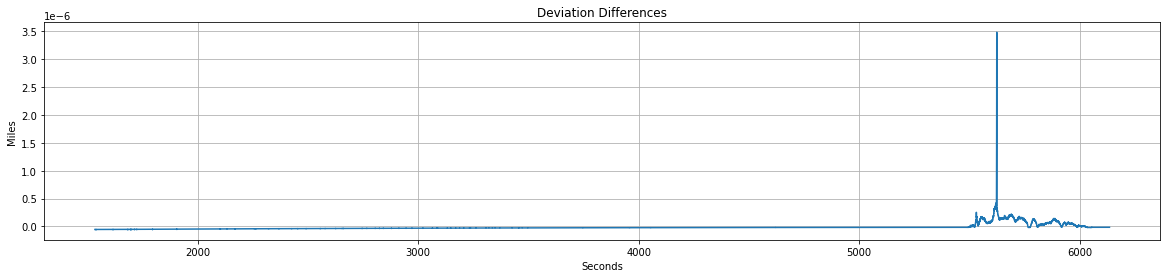

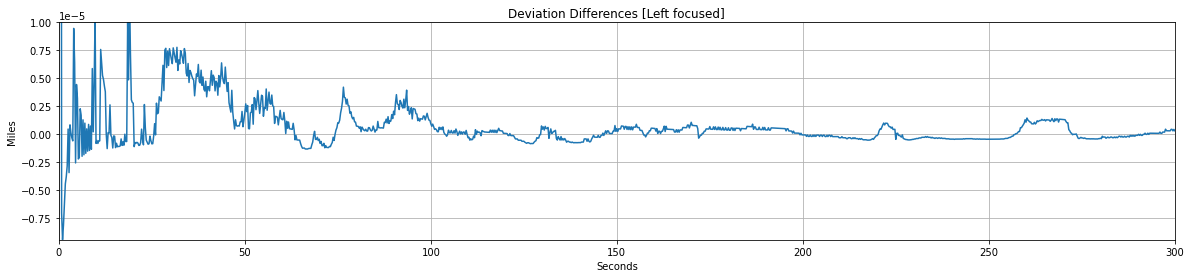

In [11]:
# Perform analysis 
original_analysis_results = perform_analysis(data)

### Applying Noise Reduction Techniques:

In [12]:
def fft_filter( noisy_signal, time, sample_rate = 50, order = 2 ):
    '''
    Applies the FFT filter to a noisy signal
    Reference: https://nehajirafe.medium.com/using-fft-to-analyse-and-cleanse-time-series-data-d0c793bb82e3
    '''
    noisy_signal_fft = fftpack.fft(noisy_signal)
    noisy_signal_amplitude = ( ( 2/len(time) * np.abs( noisy_signal_fft ) ) )
    noisy_signal_freq = ( np.abs( fftpack.fftfreq( len(time), 3/1000) ) )
    
    signal_amplitude = pd.Series(noisy_signal_amplitude).nlargest(2).round(0).astype(int).tolist()
    frequency_magnitudes = abs(noisy_signal_freq[np.where(noisy_signal_freq >= 0)])
    peak_frequency = np.sort((np.argpartition(frequency_magnitudes, -2)[-2:])/ max(time) )
    
    cutoff = peak_frequency[0]
    nyquist_frequency = 0.5 * sample_rate 
    normal_cutoff = cutoff / nyquist_frequency
    b,a = butter(order, normal_cutoff, btype='low', analog = False)
    
    return filtfilt(b,a, noisy_signal)

In [13]:
longitude_data = data[:,0]
latitude_data = data[:,1]
time = data[:,2]

# The sample rate value of 60 was ascertained after performing some trial and error.
# 60 gives for a sweet spot, between having the path too smooth, and potentially veering off the original path,
# and being too strict to the original, hence defeating the purpose of the filter. 
SAMPLE_RATE = 60
filtered_longitude = fft_filter(longitude_data, time, sample_rate=SAMPLE_RATE)
filtered_latitude =  fft_filter(latitude_data, time, sample_rate=SAMPLE_RATE)
filtered_dataframe = pd.DataFrame( { 'Longitude':filtered_longitude, 'Latitude':filtered_latitude, 'Timestamp':time} )
filtered_data = filtered_dataframe.to_numpy()

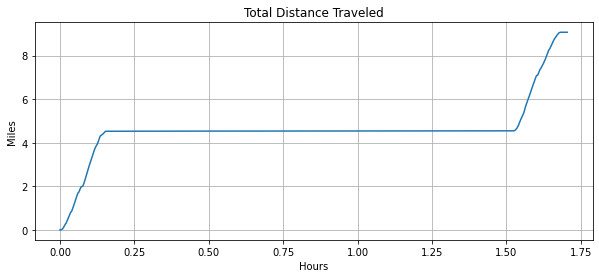

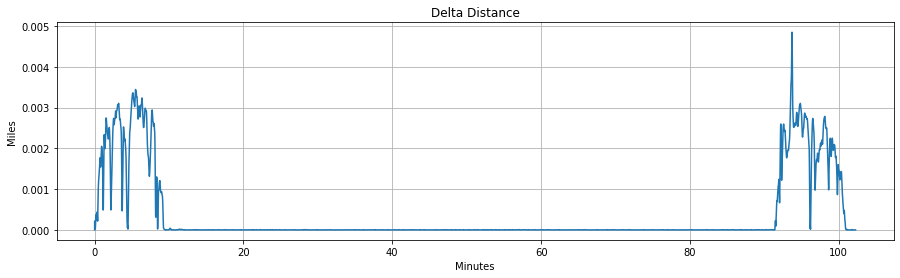

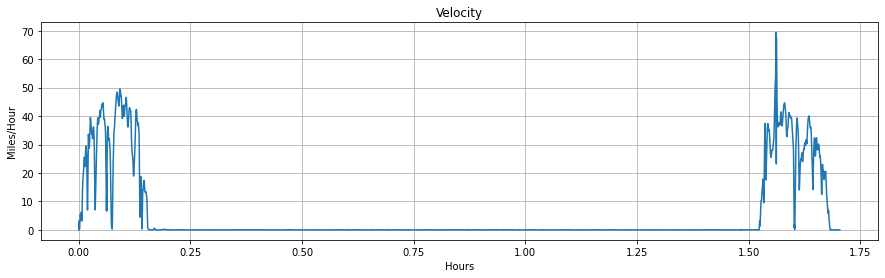

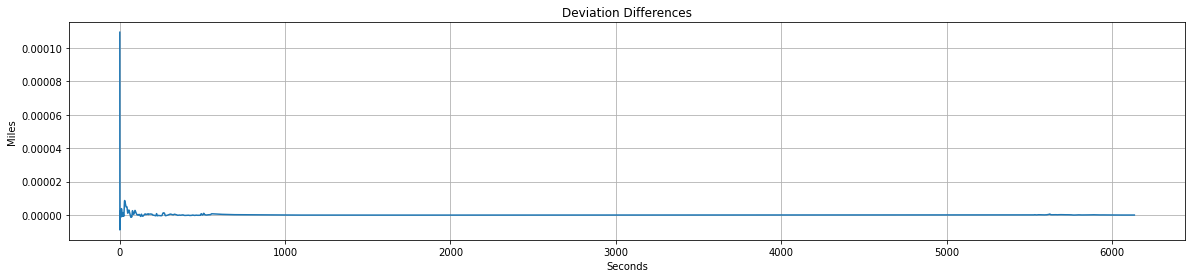

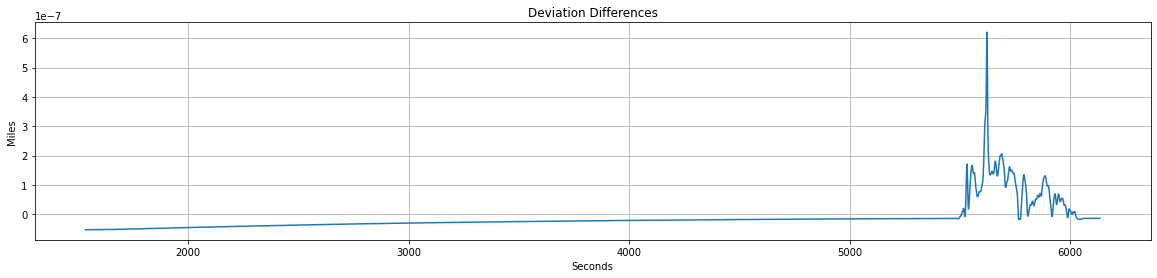

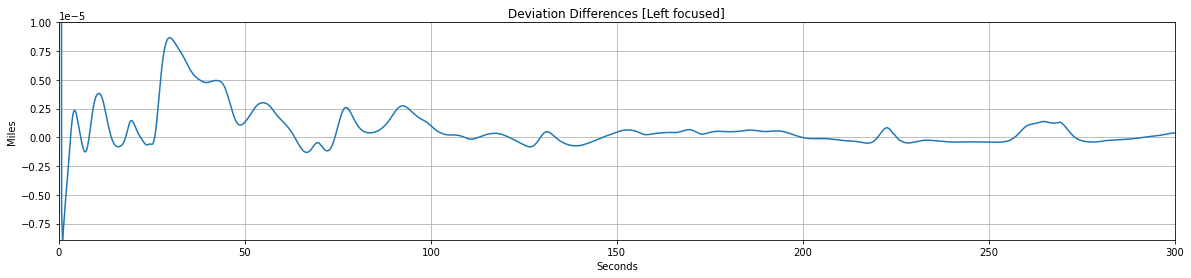

In [14]:
results_post_fft = perform_analysis(filtered_data)

---
# Clustering Location Data

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot( filtered_longitude, filtered_latitude, label='Filtered Path', linewidth=4, color='darkorange' )
plt.plot( longitude_data, latitude_data, label='Original Path', linestyle=':' )
plt.grid()
plt.legend()
plt.show()

In [16]:
len(results_post_fft['v'])

24529

In [ ]:
clustering_data = pd.DataFrame( { 'Longitude':filtered_dataframe.Longitude, 'Latitude':filtered_dataframe.Latitude,
                                  'Velocity':results_post_fft['v'], 'Seconds':filtered_dataframe.Timestamp,
                                  'DateTime':filtered_dataframe.Timestamp } )
clustering_data

In [ ]:
# Bin the data into 1-minute long bins, and take the mean. 
clustering_data['DateTime'] = pd.to_datetime(clustering_data['DateTime'], unit='s')
clustering_data.set_index('DateTime', inplace=True);
clustering_data = clustering_data.resample('1Min').mean();
clustering_data = clustering_data.reset_index();
clustering_data

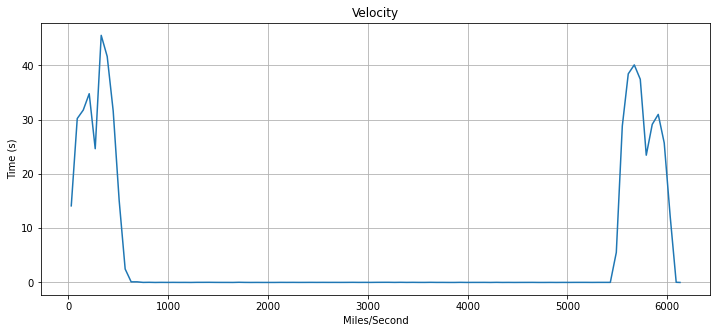

In [19]:
plt.figure(figsize=(12,5))
plt.title('Velocity')
plt.xlabel('Miles/Second')
plt.ylabel('Time (s)')
plt.plot( clustering_data.Seconds, clustering_data.Velocity )
plt.grid()
plt.show()

In [20]:
# Calculate the velocity threshold, by which we will determine what velocity datapoints amount to the car being stationary. 
velocity_threshold = clustering_data.Velocity.mean() - clustering_data.Velocity.std()
if velocity_threshold < 0:
    velocity_threshold = clustering_data.Velocity.mean()*0.3

velocity_threshold

1.5866282838026085

In [21]:
stationary_points = clustering_data[ clustering_data.Velocity < velocity_threshold ]

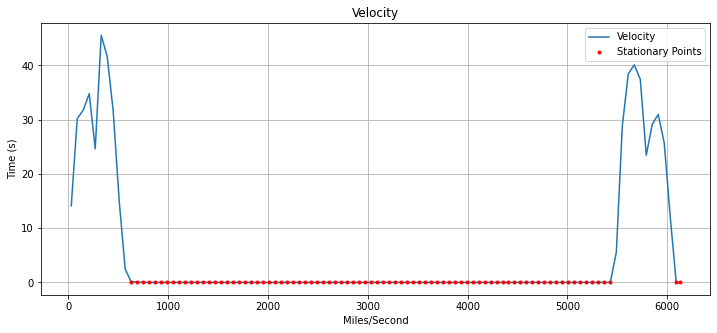

In [22]:
plt.figure(figsize=(12,5))
plt.title('Velocity')
plt.xlabel('Miles/Second')
plt.ylabel('Time (s)')
plt.plot( clustering_data.Seconds, clustering_data.Velocity, label='Velocity' )
plt.plot( stationary_points.Seconds, stationary_points.Velocity,
        marker='.', linestyle='', color='r', label='Stationary Points' )
plt.grid()
plt.legend()
plt.show()

In [23]:
NUM_DIM = 2 # The number of dimensions for our data.

# Cluster class
'''
Class to make working with Clusters easier. 
Provides method to effectively merge clusters, and keeps a running track 
of the cluster centers based on data added to it or during cluster merging.
Also consists of information regarding the parent clusters.
'''
class Cluster:
    def __init__(self, data, parents, center=None):
        global NUM_DIM
        global CLUSTER_ID
        
        CLUSTER_ID = CLUSTER_ID + 1
        self.id = CLUSTER_ID
        
        self.parents = parents
        self.center = np.zeros(NUM_DIM) if center is None else center
        self.data = []
        for datapoint in data:
            self.add(datapoint, center is None)
    
    def add(self, datapoint, setCenter):
        # 0 elements in data:
        #  center = datapt
        # 1 element in data:
        #  center = center + datapt / 2
        # n elements in data:
        #  center = n*center + 1 / n+1        
        if setCenter:
            self.center = ( len(self.data)*self.center + datapoint ) / ( len(self.data)+1 )
        self.data.append(datapoint)
    
    def __repr__(self):
        return 'ID:' + str(self.id) + '\nCenter:' + str(self.center) + '\nData:' + str(self.data)
        

In [24]:
'''
Calculates the euclidean distance between two points in n-dimensional space.
'''
def cluster_distance( clusterA, clusterB ):
    return distance(clusterA.center, clusterB.center)

In [25]:
def compute_distance_matrix():
    for index_A, id_A in enumerate( CLUSTERS.keys() ):
        DISTANCE_MATRIX[ id_A ] = dict()
        for index_B, id_B in enumerate( list(CLUSTERS.keys())[index_A+1:] ):
            DISTANCE_MATRIX[ id_A ][ id_B ] = cluster_distance( CLUSTERS[id_A], CLUSTERS[id_B] ) 

In [26]:
def mergeClusters(clusterA, clusterB):
    global CLUSTERS
    global DISTANCE_MATRIX
    global SMALLEST_CLUSTER_SIZES
    
    # Merge clusters A and B to create a new cluster.
    new_cluster_data = clusterA.data + clusterB.data
    new_cluster_center = ( clusterA.center*len(clusterA.data) + clusterB.center*len(clusterB.data) )/( len(clusterA.data) + len(clusterB.data) )
    new_cluster_parents = ( clusterA.id, clusterB.id )
    new_cluster = Cluster( new_cluster_data, new_cluster_parents, new_cluster_center ) 
    
#     # { FOR THE LAST FEW MERGES (Dr. Kinsman's Method for finding the number of clusters when Agglomerating) }
#     if len(CLUSTERS) <= 11:        
#         # Report the minimum cluster size of clusters being merged.
#         SMALLEST_CLUSTER_SIZES.append( min( len(clusterA.data), len(clusterB.data) ) )
        
    # Add merger information to linkage matrix, which will be used to construct the dendogram.
    # Data: [ cluster A ID | cluster B ID | distance between A and B | number of original datapoints in merged cluster ]
#     linkage = [ clusterA.id, clusterB.id, DISTANCE_MATRIX[ clusterA.id ][ clusterB.id ], len(new_cluster.data) ]
#     LINKAGE_MATRIX.append(linkage)    

    # Remove the row for Cluster A.
    DISTANCE_MATRIX.pop( clusterA.id, None )
    CLUSTERS.pop( clusterA.id, None )
    # Remove the row for Cluster B.
    DISTANCE_MATRIX.pop( clusterB.id, None )
    CLUSTERS.pop( clusterB.id, None )
            
    # Create new row for the new cluster.
    DISTANCE_MATRIX[new_cluster.id] = dict()
    
    # Update the Distance Matrix.
    for cluster_id in CLUSTERS.keys():
        if cluster_id == new_cluster.id:
            continue
        
        # Remove the columns for Cluster A and Cluster B.
        if clusterA.id in DISTANCE_MATRIX[cluster_id]:
            DISTANCE_MATRIX[cluster_id].pop( clusterA.id, None )
        if clusterB.id in DISTANCE_MATRIX[cluster_id]:
            DISTANCE_MATRIX[cluster_id].pop( clusterB.id, None )
        
        # Populate the row for the new cluster.        
        # CENTROID LINKAGE:
        DISTANCE_MATRIX[cluster_id][new_cluster.id] = cluster_distance(CLUSTERS[cluster_id], new_cluster )
        
    # Add new cluster to our clusters dictionary
    CLUSTERS[new_cluster.id] = new_cluster
    return new_cluster

In [27]:
'''
Find the two closest clusters.
'''
def find_closest_pair():
    global CLUSTERS
    global DISTANCE_MATRIX
    
    min_distance = np.infty
    closest_pair = [ -1, -1 ]
    for index_A, id_A in enumerate( CLUSTERS.keys() ):
        for index_B, id_B in enumerate( list(CLUSTERS.keys())[index_A+1:] ):
            dist = DISTANCE_MATRIX[ id_A ][ id_B ]
            if dist < min_distance:
                min_distance = dist
                closest_pair = [ id_A, id_B ]
    
    return closest_pair

In [28]:
CLUSTERS = dict()
CLUSTER_ID = -1
DISTANCE_MATRIX = dict()

for datapoint in stationary_points[ ['Longitude','Latitude'] ].to_numpy():
    cluster = Cluster( [datapoint], (None, None) )
    CLUSTERS[cluster.id] = cluster

In [29]:
def find_clusters(N_CLUSTERS):
    '''
    Find an N_CLUSTERS number of clusters through agglomerative hierarchical clustering. 
    '''
    global CLUSTERS
    global CLUSTER_ID 
    
    CLUSTERS = dict()
    CLUSTER_ID = -1
    
    for datapoint in stationary_points[ ['Longitude','Latitude'] ].to_numpy():
        cluster = Cluster( [datapoint], (None, None) )
        CLUSTERS[cluster.id] = cluster

    DISTANCE_MATRIX = dict()
    compute_distance_matrix()

    prototypes = []

    while len(CLUSTERS) >= N_CLUSTERS:
        closest_pair = find_closest_pair()
        new_cluster = mergeClusters( CLUSTERS[closest_pair[0]], CLUSTERS[closest_pair[1]] )

        if( len(CLUSTERS) == N_CLUSTERS ):
            for cluster in CLUSTERS.values():
                prototypes.append( cluster ) 
                
    return prototypes

In [30]:
# Figuring out an error metric, by which we can determine what value of N_CLUSTERS we should choose. 
n_cluster_metrics = dict()

for n_clusters, STOPS in [ ( n_clusters, find_clusters(n_clusters) ) for n_clusters in range(2,5) ]:
    errors = []
    for stop in STOPS:
        min_distance = min(np.array( [ distance(stop.center, point) for point in filtered_dataframe[ ['Longitude', 'Latitude'] ].to_numpy() ] ))
        errors.append( min_distance**2 )
    print(errors)        
    n_cluster_metrics[n_clusters] = sum(errors)

[2.434671756658854e-11, 5.755575043604031e-10]
[2.434671756658854e-11, 1.2688714054987673e-10, 5.990679313915085e-11]
[2.434671756658854e-11, 4.841128757919881e-10, 1.4025348941367579e-08, 1.2688714054987673e-10]


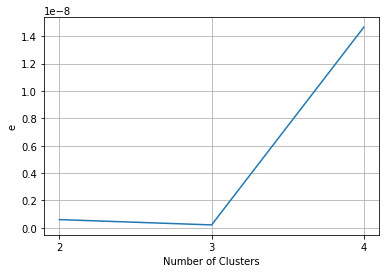

In [31]:
plt.xlabel('Number of Clusters')
plt.ylabel('e')
plt.plot( range(2,5), n_cluster_metrics.values() )
plt.xticks( range(2,5) )
plt.grid()
plt.show()

In [32]:
# Find the N_CLUSTERS value corresponding to the minimum value of our error, as calculated above. 
N_CLUSTERS = min(n_cluster_metrics, key=n_cluster_metrics.get)

In [33]:
STOPS = find_clusters(N_CLUSTERS)

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot( filtered_longitude, filtered_latitude, label='Filtered Path', linewidth=4, color='darkorange' )
plt.plot( longitude_data, latitude_data, label='Original Path', linestyle=':' )

plt.plot( STOPS[0].center[0], STOPS[0].center[1], marker='o', markersize=20, color='k' )
plt.plot( STOPS[0].center[0], STOPS[0].center[1], marker='X', linestyle='', markersize=12, color='red', label='Stop' )
    
for stop in STOPS[1:]:
    longitude = stop.center[0]
    latitude = stop.center[1]
    plt.plot( longitude, latitude, marker='o', markersize=20, color='k' )
    plt.plot( longitude, latitude, marker='X', linestyle='', markersize=12, color='red' )

plt.grid()
plt.legend()
plt.show()

---
# Writing to KML

In [35]:
kml = simplekml.Kml()

In [36]:
def create_path( kml, longitude, latitude, color = simplekml.Color.cyan, name = "Dr Kinsman's Drive" ):
    coordinates = pd.DataFrame( { 'Longitude':longitude, 'Latitude':latitude, 'Height': [ 2 for idx in range(len(longitude)) ] } ).to_numpy()
    lin = kml.newlinestring(name=name)
    lin.coords = coordinates
    lin.extrude = 1
    lin.altitudemode = simplekml.AltitudeMode.relativetoground
    lin.style.linestyle.color = color  # Default: Cyan
    lin.style.linestyle.width = 10  # 10 pixels
    
def create_placemark( kml, longitude, latitude ):
    pnt = kml.newpoint(name="Stop")
    pnt.coords = [(longitude, latitude)]
    pnt.style.labelstyle.color = simplekml.Color.red  
    pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/1.png'
    

In [37]:
create_path( kml, filtered_longitude, filtered_latitude )
create_path( kml, longitude_data, latitude_data, color = simplekml.Color.magenta, name = 'Original Path (Unfiltered)' )
for stop in STOPS:
    create_placemark( kml, stop.center[0], stop.center[1])

In [38]:
kml.save(f'{FILENAME}.kml')